In [ ]:
import pandas as pd
import re
import numpy as np
import gensim
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# spacy for lemmatization
# import spacy
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
lemmatizer = WordNetLemmatizer()

import nltk

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

In [ ]:
# for plotting
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

### Loading data

In [ ]:
import os
pwd = os.getcwd()

In [ ]:
emails = pd.read_csv(os.path.basename(pwd +'/emails.csv'))

In [ ]:
emails.count()

In [ ]:
# email_subset = emails.sample(frac=0.05, random_state=1)
email_subset = emails[:1000]
print(email_subset.shape)
print(email_subset.head())

### Data Cleaning
- We have to do topic modelling on text data, I have removed redundant imformation and kept only: email body , From and To.
- I am only using 5000 emails

In [ ]:
def parse_raw_message(raw_message):
    lines = raw_message.split('\n')
    email = {}
    message = ''
    keys_to_extract = ['from', 'to', 'date']
    for line in lines:
        if ':' not in line:
            message += line.strip()
            email['body'] = message
        else:
            pairs = line.split(':')
            key = pairs[0].lower()
            val = pairs[1].strip()
            if key in keys_to_extract:
                email[key] = val
    return email

In [ ]:
def parse_into_emails(messages):
    emails = [parse_raw_message(message) for message in messages]
    return {
        'body': map_to_list(emails, 'body'),
        'to': map_to_list(emails, 'to'),
        'from_': map_to_list(emails, 'from'),
        'date': map_to_list(emails, 'date'),
        'TC': 0,
        'SN': 0,
        'KS': 0,
        'OT': 0
    }

In [ ]:
def map_to_list(emails, key):
    results = []
    for email in emails:
        if key not in email:
            results.append('')
        else:
            results.append(email[key])
    return results

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip(' ')
    return text

In [ ]:
email_df = pd.DataFrame(parse_into_emails(email_subset.message))
email_df.head()

In [13]:
email_df.count()

body     1000
to       1000
from_    1000
date     1000
TC       1000
SN       1000
KS       1000
OT       1000
dtype: int64

In [14]:
email_df['date'] = email_df['date'].str[4:16]
email_df['body'][11]

"Lucy,Open them and save in the rentroll folder.  Follow these steps so you don'tmisplace these files.1.  Click on Save As4.  Click on the appropriate folderPhillip"

In [15]:
# To check there are no empty columns
email_df.drop(email_df.query(
    "body == '' | to == '' | from_ == '' | date == ''"
).index, inplace=True)

### Remove punctuation/lower casing
- Preprocessing on the content to make it more amenable for analysis

In [16]:
# Remove punctuation
email_df['text_processed'] = \
email_df['text_processed'] = email_df['body'].str.replace(r'[^\w\s]','')
# Convert the textto lowercase
email_df['text_processed'] = \
email_df['text_processed'].map(lambda x: x.lower())


In [17]:
email_df['text_processed'] = email_df['text_processed'].map(lambda com : clean_text(com))

In [18]:
email_df['text_processed'][11]

'lucyopen them and save in the rentroll folder follow these steps so you dontmisplace these files1 click on save as4 click on the appropriate folderphillip'

### Exploratory Analysis
Wordcloud package to get a visual representation of most common words

In [19]:
# Import the wordcloud library
from wordcloud import WordCloud

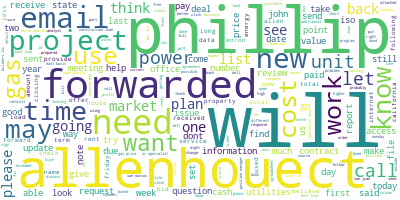

In [20]:
# Join the different processed titles together.
long_string = ','.join(list(email_df['text_processed'].values))# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()


### LDA Analysis : Transform data in a format that will serve as an input for training LDA model

In [21]:
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser
import nltk
from nltk import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shrad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shrad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Analyzing text with TF-IDF

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(stop_words='english', max_df=0.50, min_df=2)
X = vect.fit_transform(email_df.text_processed)

In [27]:
email_df.to_pickle('email.pickle')
from IPython.display import clear_output

In [31]:
def manually_label(email_file):
    print('Is this sentence? Type 1 if team communication ,Type 2: social networking, Type 3: knowldge shairng and Type 4: others . \n')
    df = pd.read_pickle(email_file)
    for index, row in df.iterrows():
#         if pd.isnull(row.label):
            print(row.text_processed)
            label = input()
            if label in '1':
                df.loc[index, 'TC'] = 1
            if label in '2':
                df.loc[index, 'SN'] = 1
            if label in '3':
                df.loc[index, 'KS'] = 1
            if label in '4':
                df.loc[index, 'OT'] = 1
            clear_output()
            df.to_pickle('email.pickle')
            
    print('No more labels to classify!')
    


In [ ]:
manually_label('email.pickle')

---------------------- Forwarded by Phillip K Allen/HOU/ECT on 10/16/2000Phillip,> As discussed  during our phone conversation, In a Parallon 75 microturbine> power generation deal for a national accounts customer, I am developing a> proposal to sell power to customer at fixed or collar/floor price. To do> so I need a corresponding term gas price for same. Microturbine is an> onsite generation product developed by Honeywell to generate electricity> on customer site (degen). using natural gas. In doing so,  I need your> best fixed price forward gas price deal for 1, 3, 5, 7 and 10 years for> annual/seasonal supply to microturbines to generate fixed kWh for> customer. We have the opportunity to sell customer kWh 's using> microturbine or sell them turbines themselves. kWh deal must have limited/> no risk forward gas price to make deal work. Therein comes Sempra energy> gas trading, truly you.>> We are proposing installing 180 - 240 units across a large number of> stores (60-100) in San D

In [ ]:
def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df
def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [ ]:
features = vect.get_feature_names()
print top_feats_in_doc(X, features, 1, 10)

In [ ]:
stop_words = stopwords.words('english')# replace with space
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [ ]:
print(email_df.iloc[11]['text_processed'])

In [ ]:
data = email_df.text_processed.values.tolist()

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts):
    texts_out = []
    for sent in texts:
        texts_out.append([lemmatizer.lemmatize(i) for i in sent])
    return texts_out

In [ ]:
data_words = list(sent_to_words(data))

In [ ]:
print(data_words[11])

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

In [ ]:
# Faster way to get a sentence clubbed as a trigram/bigram
# bigram_mod = Phraser(bigram)
# trigram_mod = Phraser(trigram)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
print(bigram_mod[data_words[11]])

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [ ]:
#  Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [ ]:
data_lemmatized = lemmatization(data_words_bigrams)

In [ ]:
print(data_lemmatized[11])

In [ ]:
import gensim.corpora as corpora# Create Dictionary
dictionary = corpora.Dictionary(data_lemmatized)# Create Corpus

In [ ]:
print('Number of unique words in initital documents:', len(dictionary))

In [ ]:
# Filter out words that occur less than 10 documents, or more than 20% of the documents.
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
print('Number of unique words after removing rare and common words:', len(dictionary))

In [ ]:
texts = data_lemmatized# Term Document Frequency
corpus = [dictionary.doc2bow(text) for text in texts]# View

In [ ]:
import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [ ]:
print(corpus[:1])

In [ ]:
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 20);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);

In [ ]:
from pprint import pprint# number of topics
num_topics = 10# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=num_topics,
#                                            chunksize=500,
                                      per_word_topics=True)# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
get_lda_topics(lda_model, 10)

In [ ]:
pyLDAvis.enable_notebook()
warnings.filterwarnings("ignore", category=DeprecationWarning)